## Prerequisites

In [ ]:
%%capture
!pip install eeg-filters
!pip install ffmpeg # to change AV file format
!pip install madmom # MADMOM package
!pip install mne    # package for preprocessing EEG data
!pip install mne[hdf5]
!pip install torchsummaryX

In [ ]:
!pip install mir_eval

     |████████████████████████████████| 90 kB 3.5 MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100721 sha256=08e55f10c9c529c34e8451ff139b306c377c88a6d552fc6546e96a042c7a0984
  Stored in directory: /root/.cache/pip/wheels/18/5a/46/d2527ff1fd975e1a793375e6ed763bfe4d3ea396b7cdc470eb
Successfully built mir-eval


In [ ]:
import os
import ffmpeg
import madmom
import matplotlib.pyplot as plt
import mne
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from madmom.features import beats, onsets
from scipy import io
from scipy.signal import butter, freqz, lfilter
from torchsummaryX import summary
import mir_eval
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)
# !ls '/content/drive/MyDrive/2022 Spring/11-785 Introduction to Deep Learning/Project'

Mounted at /content/drive


In [ ]:
data_folder =  "/content/drive/MyDrive/11785 Project/data"


## Preprocessing

In [ ]:
wav_data = "/content/drive/MyDrive/2022 Spring/11-785 Introduction to Deep Learning/Project/data/songs_wav"
mat_data = "/content/drive/MyDrive/2022 Spring/11-785 Introduction to Deep Learning/Project/data/songs_mat"

In [ ]:
load_mat = io.loadmat(mat_data +'/song21_Imputed.mat',  struct_as_record=True)

print(load_mat.keys())
print(type(load_mat['data21']))
# dict_keys(['__header__', '__version__', '__globals__', 'data21', 'fs', 'subs21'])

dict_keys(['__header__', '__version__', '__globals__', 'data21', 'fs', 'subs21'])
<class 'numpy.ndarray'>


In [ ]:
# actual EEG data
print(load_mat['data21'].shape) # 125 channels x N time steps x 20 subjects
eeg_data = torch.permute(torch.tensor(load_mat['data21']), (2,0,1))
print(eeg_data.shape) # 20 x N x 125

(125, 34795, 20)
torch.Size([20, 125, 34795])


In [ ]:
pad_length = 37500 - eeg_data.shape[2]
eeg_data = F.pad(eeg_data, (0,0, 0,0, 0, pad_length), mode='constant', value=0)
# print("padded EEG data shape: ", eeg_data.shape)

# segment into one second blocks
eeg_split = np.split(eeg_data, 300, axis=2)
split_eeg = []
for split in eeg_split:
  x = np.split(split, 20, axis=0)
  for y in x:
    split_eeg.append(torch.squeeze(y))

print(split_eeg[1].shape)
print(len(split_eeg))

torch.Size([125, 125])
6000


we filter the EEG data with a bandpass filter (0.1 – 40 Hz) and zero-pad the dataset uniformly to a length of 37500 samples (5 min), since the longest song in the dataset is around five minutes long

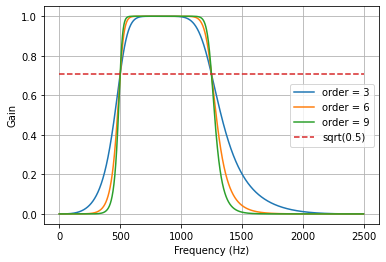

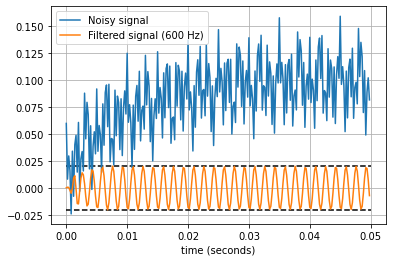

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
          '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.
T = 0.05
nsamples = T * fs
t = np.arange(0, nsamples) / fs
a = 0.02
f0 = 600.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)

# x = EEGdata[0]

plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')

y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

## Attempting to Annotate Music with MADMOM ODF RNN

In [ ]:
# from scipy.io import wavfile
# samplerate, data = wavfile.read('/content/first_fires.wav')

In [ ]:
# proc1.reset()
proc1 = madmom.features.onsets.OnsetPeakPickingProcessor(fps = 1.28) #What should fps be?
act1 = madmom.features.onsets.RNNOnsetProcessor()('/content/first_fires.wav') 
onset_values = proc1(act1) 
print(onset_values)

[1.87500000e+01 8.43750000e+01 1.03906250e+02 ... 2.11773438e+04
 2.12421875e+04 2.12828125e+04]


In [ ]:
print(len(onset_values))

import os
import wave

with wave.open('/content/first_fires.wav', "rb") as wave_file:
  frame_rate = wave_file.getframerate()
print(frame_rate)

1200
48000


In [ ]:
#lmao this is so wrong

song_labels = np.zeros(37500)

for i in onset_values:
  song_labels[int(i)] = 1

In [ ]:
print(song_labels[0:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
split_song_labels = np.split(song_labels, 300)
print(split_song_labels[0].shape)

(125,)


# Dataloader

In [ ]:
class UserDataset(torch.utils.data.Dataset):
     def __init__(self, data_path, partition= "train", user_id = "0",context=0): # You can use partition to specify train or dev

        self.X_dir = data_path + "/users_mat/" # TODO: get mfcc directory path
        self.Y_dir = data_path + "/ground_truths/" # TODO: get transcript path

        self.X_files = os.listdir(self.X_dir)# TODO: list files in the mfcc directory
        #print(self.X_files)
        if partition == 'train':
            self.X_files = [f for f in self.X_files if user_id not in f]
            val = 19
        else:
            self.X_files = [f for f in self.X_files if user_id in f]
            val = 1
        
        self.Y_onehot = np.load(data_path+'/ground_truths/one_hot.npy')
        self.Y_timestamps = np.load(data_path+'/ground_truths/timestamps.npy',allow_pickle=True)
        # self.Y_files = os.listdir(self.Y_dir)# TODO: list files in the transcript directory
        self.XXX = []
        self.YYY = []
        self.timestamps = []
        self.timestamps_length = []
        self.context = context


        #print(len(self.Y_timestamps))
        #2239 max
        # for i in self.Y_timestamps:
        #   print(len(i))
        
        for i in self.Y_timestamps:
          # print(i.shape)
          self.timestamps_length.append(len(i))
          self.timestamps.append(np.pad(i, (0, 2239-len(i)), 'constant'))

        for x_file in self.X_files:
            Xtemp =  io.loadmat(data_folder+'/users_mat/'+x_file)
            data = Xtemp['data']
            #print("data",data.shape)
            #print("data len",len(data))
            for i in range(len(data)):
              #print("1",i.shape)
              temp = np.reshape(data[i],(300,125,125))
              #print("1 temp shape")


              # for context

              # if i==0:
              #   temp = np.pad(temp,((self.context,self.context),(0,0),(0,0)))
              #   split_temp = np.split(temp,300 + (2*self.context))

              # else:
              #   temp = np.pad(temp,((0,self.context),(0,0),(0,0)))
              #   split_temp = np.split(temp,300 + (1*self.context))


              # temp2 = []
              # for i in range(self.context, temp.shape[0]-self.context):
              #   temp2.append(temp[i-self.context:i+self.context+1])

              # temp2 = np.array(temp2)
              # temp = np.reshape(temp2,(300, temp2.shape[1]*temp2.shape[2], 125))

              #print("2",temp.shape)


              #print(len(split_temp))
              # print("3",split_temp.shape)
              split_temp = np.split(temp,300)
              self.XXX.extend(split_temp)
            

            for i in range(len(self.Y_onehot)):
                #print("i ", i.shape)
                temp = np.split(self.Y_onehot[i], 300)
                # if i==0:
                #   temp = np.pad(temp,((self.context,self.context),(0,0)))
                # else:
                #   temp = np.pad(temp,((0,self.context),(0,0)))

                #print(temp.shape)

                self.YYY.extend(temp)
                

        # print("lengths")
        # print(len(self.timestamps_length))
        # print(len(self.timestamps))
        # print(len(self.YYY))
        # print(len(self.XXX))

        self.XXX = np.array(self.XXX)
        self.YYY = np.array(self.YYY)

        print("XXX shape ",self.XXX.shape)
        print("YYY ",self.YYY.shape)

        self.XXX = np.pad(self.XXX,pad_width=[(self.context,self.context),(0,0),(0,0),(0,0)])

        # print("XXX shape context ",self.XXX.shape)


     def __len__(self):
        return len(self.YYY)

     def __getitem__(self, ind):

        #x = self.XXX[ind:ind+(2*self.context)+1]
        # print("here")
        # print(self.XXX.shape)
        #x = np.reshape(x,(-1, 125))
        # print(self.XXX.shape)

        x = self.XXX[ind:ind+(2*self.context)+1]
        y = self.YYY[ind]
        # print(y.shape)

        # y = y.flatten()

        # print(self.YYY.shape)
        # print("bye")
        return x, y, self.timestamps, self.timestamps_length
    
    # def collate_fn(batch):

    #     batch_x = [x for x,y in batch]
    #     batch_y = [y for x,y in batch]

    #     batch_x_pad = pad_sequence(batch_x,batch_first=True) # TODO: pad the sequence with pad_sequence (already imported)
    #     lengths_x = [len(x) for x in batch_x]# TODO: Get original lengths of the sequence before padding

    #     batch_y_pad = pad_sequence(batch_y,batch_first=True)# TODO: pad the sequence with pad_sequence (already imported)
    #     lengths_y = [len(y) for y in batch_y]# TODO: Get original lengths of the sequence before padding

    #     return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)



## Fully Connected Network

In [ ]:
class Network(torch.nn.Module):

    def __init__(self,context):
        super(Network, self).__init__()
        
        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(125*125*(2*context+1), 1024),
            nn.LeakyReLU(),
            #nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 125)

            
        )

    def forward(self, x):
        x = self.flatten(x)
        #print(x.shape)
        x = self.layers(x)
        return x

# eeg = split_eeg[0]
# print(eeg.shape)

# summary(model, eeg.float().cuda())

In [ ]:

# train data loader
users_train = UserDataset(data_folder, partition= "train", user_id = "user0",context=1)
train_loader = torch.utils.data.DataLoader(users_train, batch_size=300, shuffle=True,  num_workers=4)
users_valid = UserDataset(data_folder, partition= "valid", user_id = "user0",context=1)
val_loader = torch.utils.data.DataLoader(users_valid, batch_size=300, shuffle=False, num_workers=4)

print(len(users_train))
print(users_train[0][0].shape)
print(len(users_train))

# print(len)

XXX shape  (57000, 1, 125, 125)
YYY  (57000, 125)
XXX shape  (3000, 1, 125, 125)
YYY  (3000, 125)
57000
(3, 1, 125, 125)
57000


In [ ]:
model = Network(users_valid.context).cuda()
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.6, patience=2, mode='min')

Network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=46875, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=125, bias=True)
  )
)


In [ ]:
print(len(val_loader))
model = model.cuda()

10


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve
def validation(model,criterion,optimizer):
  model.eval()
  batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Validation')
  val_loss = 0
  f1  = np.zeros(10)
  p  = np.zeros(10)
  r  = np.zeros(10)
  auc = 0

  f1s  = np.zeros(10)
  ps  = np.zeros(10)
  rs  = np.zeros(10)


  for batch_idx, batch in enumerate(val_loader):
      optimizer.zero_grad()

      data = batch[0].float().cuda()
      #print(data.shape)
      #print(data.shape)
      label = batch[1].cuda()
      # print("labels",label.shape,label.int().flatten().shape)
      # print(label.int().flatten())

      with torch.no_grad():

        output = model(data)
        # print("output",output.shape,output.flatten().shape)
        loss = criterion((output), label.float())


      output_s = output #nn.Sigmoid()(output)
      temp_output = torch.reshape(output_s,(1,300*125))
      temp_output = temp_output.cpu().detach().numpy()
      temp_output = np.reshape(temp_output,(37500))

      threshold = 0.5 #np.mean(temp_output)/2
      # binary_output = np.where(temp_output > threshold, 1, 0)


      # #print(len(binary_output))
      # indices = np.where(binary_output==1)[0]
      # #print(indices)
      # predicted = []
      # for i in indices:
      #   predicted.append(i/125) 

      
      indices = madmom.features.onsets.peak_picking(temp_output,threshold)
      #print(indices.shape)
      predicted = indices/125
      #print(predicted.shape)
      #print("len",len(batch[2]))

      #print(len(batch[2][0]))
      length = batch[3][batch_idx%10][0]
      #print('lalala',length)

      gt_timestamp = batch[2][batch_idx%10][0][:length]
      # print(len(gt_timestamp))
      # print("hi")
      # print(len(predicted))


      metrics = mir_eval.onset.f_measure(np.array(gt_timestamp),np.array(predicted))
      f1[batch_idx%10]+=(metrics[0])
      p[batch_idx%10]+=(metrics[1])
      r[batch_idx%10]+=(metrics[2])

      # print(label.shape)
      # print(np.unique(label.numpy()))
      auc+= roc_auc_score(label.cpu().flatten(),output.cpu().flatten())
    

      # f1s[batch_idx%10]+= f1_score(label.flatten(),output.flatten())
      # ps[batch_idx%10]+=  precision_score(label.flatten(),output.flatten())
      # rs[batch_idx%10]+= recall_score(label.flatten(),output.flatten())


      val_loss += loss

      batch_bar.set_postfix(loss="{:.04f}".format(float(val_loss / (batch_idx + 1))))

      # loss.backward()
      # optimizer.step()

      batch_bar.update()

  batch_bar.close()


  # print("\n")
  # print(gt_timestamp)

  # print("hiii")
  # print(predicted)

  # print(len(gt_timestamp))
  # print(len(predicted))


  
  return val_loss/len(val_loader), f1, p, r, auc/len(val_loader)

In [ ]:
epochs = 50
for epoch in range(1, epochs+1):
  batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
  model.train()

  total_loss = 0

  for batch_idx, batch in enumerate(train_loader):
    optimizer.zero_grad()

    data = batch[0].float().cuda()
    # print(data.shape)
    label = batch[1].cuda()
    # print(label.shape)
    # binary_output = np.where(output > 0.5, 1, 0)

    output = model(data).cuda()
    #print(output.shape)

    # print(output.shape)


    loss = criterion(output, label.float())
    total_loss += loss

    batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (batch_idx + 1))), lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
    loss.backward()
    optimizer.step()

    batch_bar.update()
  
  val_loss, f1, p, r, auc  = validation(model,criterion,optimizer)#,scheduler)
  #scheduler.step(val_loss)

  model.train()

  

  batch_bar.close()

  print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}, Validation Loss {:.04f}, F1 Score {:.04f}, Precision {:.04f}, Recall {:.04f}, AUC {:.04f}".format(
        epoch,
        epochs,
        float(total_loss / (len(train_loader))),
        float(optimizer.param_groups[0]['lr']),val_loss,np.mean(f1),np.mean(p),np.mean(r),auc))
  
  # print("F1 Score {:.04f}, Precision {:.04f}, Recall {:.04f}".format(np.mean(f1s),np.mean(ps),np.mean(rs)))
    
#     wandb.log(metrics)
# wandb.finish()

Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.10s/it, loss=0.1423]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.92it/s, loss=0.1613]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.92it/s, loss=0.1614]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  3.99it/s, loss=0.1522]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 1/50: Train Loss 0.3884, Learning Rate 0.0010, Validation Loss 0.1746, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6181


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:10,  1.11s/it, loss=0.1396]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:10,  1.11s/it, loss=0.1601]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.82it/s, loss=0.1591]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.82it/s, loss=0.1492]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 2/50: Train Loss 0.1859, Learning Rate 0.0010, Validation Loss 0.1718, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6343


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.08s/it, loss=0.1399]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.96it/s, loss=0.1600]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.96it/s, loss=0.1593]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.15it/s, loss=0.1495]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 3/50: Train Loss 0.1812, Learning Rate 0.0010, Validation Loss 0.1718, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6351


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:10,  1.13s/it, loss=0.1384]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.89it/s, loss=0.1590]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.89it/s, loss=0.1585]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  3.89it/s, loss=0.1488]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 4/50: Train Loss 0.1793, Learning Rate 0.0010, Validation Loss 0.1719, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6312


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.04s/it, loss=0.1389]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.01it/s, loss=0.1594]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  3.15it/s, loss=0.1582]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  3.15it/s, loss=0.1484]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 5/50: Train Loss 0.1767, Learning Rate 0.0010, Validation Loss 0.1713, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6368


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:00<00:08,  1.00it/s, loss=0.1381]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.10it/s, loss=0.1586]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  3.27it/s, loss=0.1576]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  3.27it/s, loss=0.1479]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 6/50: Train Loss 0.1742, Learning Rate 0.0010, Validation Loss 0.1717, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6341


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.06s/it, loss=0.1374]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1586]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1575]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.14it/s, loss=0.1474]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 7/50: Train Loss 0.1708, Learning Rate 0.0010, Validation Loss 0.1723, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6307


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.06s/it, loss=0.1372]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.95it/s, loss=0.1582]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.95it/s, loss=0.1571]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  3.99it/s, loss=0.1471]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 8/50: Train Loss 0.1657, Learning Rate 0.0010, Validation Loss 0.1730, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6227


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.03s/it, loss=0.1379]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.03s/it, loss=0.1588]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.92it/s, loss=0.1577]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.92it/s, loss=0.1476]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 9/50: Train Loss 0.1615, Learning Rate 0.0010, Validation Loss 0.1742, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6110


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.07s/it, loss=0.1383]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.07s/it, loss=0.1593]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.86it/s, loss=0.1580]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.86it/s, loss=0.1479]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 10/50: Train Loss 0.1587, Learning Rate 0.0010, Validation Loss 0.1749, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6031


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.04s/it, loss=0.1379]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1593]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1580]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.10it/s, loss=0.1479]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 11/50: Train Loss 0.1558, Learning Rate 0.0010, Validation Loss 0.1751, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.6029


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.08s/it, loss=0.1396]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.96it/s, loss=0.1602]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.96it/s, loss=0.1589]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.11it/s, loss=0.1493]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 12/50: Train Loss 0.1532, Learning Rate 0.0010, Validation Loss 0.1765, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.5910


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.03s/it, loss=0.1388]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1608]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1588]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.26it/s, loss=0.1489]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 13/50: Train Loss 0.1499, Learning Rate 0.0010, Validation Loss 0.1775, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.5882


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.11s/it, loss=0.1405]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.11s/it, loss=0.1620]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.85it/s, loss=0.1604]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  30%|███       | 3/10 [00:01<00:02,  2.85it/s, loss=0.1502]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 14/50: Train Loss 0.1469, Learning Rate 0.0010, Validation Loss 0.1783, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.5886


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.04s/it, loss=0.1406]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1619]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:03,  2.02it/s, loss=0.1603]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.16it/s, loss=0.1506]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 15/50: Train Loss 0.1440, Learning Rate 0.0010, Validation Loss 0.1783, F1 Score 0.0000, Precision 0.0000, Recall 0.0000, AUC 0.5914


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:10,  1.13s/it, loss=0.1414]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  1.87it/s, loss=0.1627]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  3.99it/s, loss=0.1518]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  60%|██████    | 6/10 [00:01<00:00,  5.70it/s, loss=0.1640]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 16/50: Train Loss 0.1412, Learning Rate 0.0010, Validation Loss 0.1805, F1 Score 0.0003, Precision 0.1500, Recall 0.0002, AUC 0.5817


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  20%|██        | 2/10 [00:01<00:04,  2.00it/s, loss=0.1634]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.09it/s, loss=0.1523]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.09it/s, loss=0.1628]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  60%|██████    | 6/10 [00:01<00:00,  5.90it/s, loss=0.1651]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 17/50: Train Loss 0.1381, Learning Rate 0.0010, Validation Loss 0.1812, F1 Score 0.0002, Precision 0.1000, Recall 0.0001, AUC 0.5863


Validation:  10%|█         | 1/10 [00:01<00:09,  1.08s/it, loss=0.1430]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.08s/it, loss=0.1647]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  50%|█████     | 5/10 [00:01<00:01,  4.65it/s, loss=0.1641]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  70%|███████   | 7/10 [00:01<00:00,  6.26it/s, loss=0.1676]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")


Epoch 18/50: Train Loss 0.1352, Learning Rate 0.0010, Validation Loss 0.1830, F1 Score 0.0005, Precision 0.4000, Recall 0.0003, AUC 0.5812


Validation:  30%|███       | 3/10 [00:01<00:02,  3.02it/s, loss=0.1550]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  50%|█████     | 5/10 [00:01<00:00,  5.26it/s, loss=0.1676]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  90%|█████████ | 9/10 [00:01<00:00,  8.17it/s, loss=0.1792]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")


Epoch 19/50: Train Loss 0.1322, Learning Rate 0.0010, Validation Loss 0.1847, F1 Score 0.0011, Precision 0.3500, Recall 0.0006, AUC 0.5768


Validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  10%|█         | 1/10 [00:01<00:09,  1.10s/it, loss=0.1455]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.02it/s, loss=0.1557]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  80%|████████  | 8/10 [00:01<00:00,  7.20it/s, loss=0.1729]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  80%|████████  | 8/10 [00:01<00:00,  7.20it/s, loss=0.1805]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarni

Epoch 20/50: Train Loss 0.1295, Learning Rate 0.0010, Validation Loss 0.1859, F1 Score 0.0007, Precision 0.2333, Recall 0.0004, AUC 0.5782


Validation:  10%|█         | 1/10 [00:01<00:09,  1.03s/it, loss=0.1475]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.07it/s, loss=0.1574]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  50%|█████     | 5/10 [00:01<00:01,  4.94it/s, loss=0.1677]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  50%|█████     | 5/10 [00:01<00:01,  4.94it/s, loss=0.1701]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")


Epoch 21/50: Train Loss 0.1267, Learning Rate 0.0010, Validation Loss 0.1871, F1 Score 0.0004, Precision 0.2500, Recall 0.0002, AUC 0.5738


Validation:  20%|██        | 2/10 [00:01<00:04,  1.99it/s, loss=0.1687]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.12it/s, loss=0.1580]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  40%|████      | 4/10 [00:01<00:01,  4.12it/s, loss=0.1688]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")
Validation:  80%|████████  | 8/10 [00:01<00:00,  7.64it/s, loss=0.1836]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")


Epoch 22/50: Train Loss 0.1238, Learning Rate 0.0010, Validation Loss 0.1895, F1 Score 0.0005, Precision 0.2000, Recall 0.0003, AUC 0.5752


Epoch 23/50: Train Loss 0.1205, Learning Rate 0.0010, Validation Loss 0.1915, F1 Score 0.0025, Precision 0.6450, Recall 0.0012, AUC 0.5742


Validation:  90%|█████████ | 9/10 [00:01<00:00,  8.36it/s, loss=0.1873]/usr/local/lib/python3.7/dist-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")


Epoch 24/50: Train Loss 0.1176, Learning Rate 0.0010, Validation Loss 0.1936, F1 Score 0.0020, Precision 0.3033, Recall 0.0010, AUC 0.5741


Epoch 25/50: Train Loss 0.1145, Learning Rate 0.0010, Validation Loss 0.1943, F1 Score 0.0031, Precision 0.6214, Recall 0.0015, AUC 0.5739


Epoch 26/50: Train Loss 0.1115, Learning Rate 0.0010, Validation Loss 0.1976, F1 Score 0.0054, Precision 0.5479, Recall 0.0027, AUC 0.5722


Epoch 27/50: Train Loss 0.1088, Learning Rate 0.0010, Validation Loss 0.2003, F1 Score 0.0068, Precision 0.5598, Recall 0.0034, AUC 0.5703


Epoch 28/50: Train Loss 0.1060, Learning Rate 0.0010, Validation Loss 0.2035, F1 Score 0.0064, Precision 0.5151, Recall 0.0032, AUC 0.5701


Epoch 29/50: Train Loss 0.1033, Learning Rate 0.0010, Validation Loss 0.2046, F1 Score 0.0090, Precision 0.5027, Recall 0.0046, AUC 0.5722


Epoch 30/50: Train Loss 0.1007, Learning Rate 0.0010, Validation Loss 0.2075, F1 Score 0.0108, Precision 0.5070, Recall 0.0055, AUC 0.5696


Epoch 31/50: Train Loss 0.0984, Learning Rate 0.0010, Validation Loss 0.2103, F1 Score 0.0133, Precision 0.5378, Recall 0.0067, AUC 0.5711


Epoch 32/50: Train Loss 0.0959, Learning Rate 0.0010, Validation Loss 0.2117, F1 Score 0.0132, Precision 0.4936, Recall 0.0067, AUC 0.5707


Epoch 33/50: Train Loss 0.0935, Learning Rate 0.0010, Validation Loss 0.2148, F1 Score 0.0168, Precision 0.5082, Recall 0.0086, AUC 0.5705


Epoch 34/50: Train Loss 0.0916, Learning Rate 0.0010, Validation Loss 0.2161, F1 Score 0.0191, Precision 0.4903, Recall 0.0097, AUC 0.5693


Epoch 35/50: Train Loss 0.0895, Learning Rate 0.0010, Validation Loss 0.2177, F1 Score 0.0199, Precision 0.4851, Recall 0.0102, AUC 0.5707


Epoch 36/50: Train Loss 0.0875, Learning Rate 0.0010, Validation Loss 0.2208, F1 Score 0.0293, Precision 0.5361, Recall 0.0151, AUC 0.5690


Epoch 37/50: Train Loss 0.0856, Learning Rate 0.0010, Validation Loss 0.2226, F1 Score 0.0305, Precision 0.5422, Recall 0.0158, AUC 0.5690


Epoch 38/50: Train Loss 0.0840, Learning Rate 0.0010, Validation Loss 0.2252, F1 Score 0.0339, Precision 0.5457, Recall 0.0176, AUC 0.5684


Epoch 39/50: Train Loss 0.0825, Learning Rate 0.0010, Validation Loss 0.2272, F1 Score 0.0374, Precision 0.5402, Recall 0.0194, AUC 0.5660


Epoch 40/50: Train Loss 0.0805, Learning Rate 0.0010, Validation Loss 0.2294, F1 Score 0.0410, Precision 0.5358, Recall 0.0214, AUC 0.5703


Epoch 41/50: Train Loss 0.0790, Learning Rate 0.0010, Validation Loss 0.2320, F1 Score 0.0395, Precision 0.5644, Recall 0.0206, AUC 0.5682


Epoch 42/50: Train Loss 0.0774, Learning Rate 0.0010, Validation Loss 0.2339, F1 Score 0.0476, Precision 0.5469, Recall 0.0250, AUC 0.5687


Epoch 43/50: Train Loss 0.0760, Learning Rate 0.0010, Validation Loss 0.2372, F1 Score 0.0496, Precision 0.5371, Recall 0.0261, AUC 0.5688


Epoch 44/50: Train Loss 0.0747, Learning Rate 0.0010, Validation Loss 0.2377, F1 Score 0.0501, Precision 0.5410, Recall 0.0264, AUC 0.5667


Epoch 45/50: Train Loss 0.0735, Learning Rate 0.0010, Validation Loss 0.2394, F1 Score 0.0550, Precision 0.5315, Recall 0.0292, AUC 0.5687


Epoch 46/50: Train Loss 0.0722, Learning Rate 0.0010, Validation Loss 0.2426, F1 Score 0.0566, Precision 0.5263, Recall 0.0301, AUC 0.5666


Epoch 47/50: Train Loss 0.0707, Learning Rate 0.0010, Validation Loss 0.2439, F1 Score 0.0609, Precision 0.5302, Recall 0.0325, AUC 0.5645


Epoch 48/50: Train Loss 0.0696, Learning Rate 0.0010, Validation Loss 0.2455, F1 Score 0.0629, Precision 0.5298, Recall 0.0336, AUC 0.5643


Epoch 49/50: Train Loss 0.0688, Learning Rate 0.0010, Validation Loss 0.2478, F1 Score 0.0619, Precision 0.5330, Recall 0.0330, AUC 0.5667


Epoch 50/50: Train Loss 0.0677, Learning Rate 0.0010, Validation Loss 0.2491, F1 Score 0.0694, Precision 0.5391, Recall 0.0373, AUC 0.5652


In [ ]:
#  validation(model,criterion,optimizer)

In [ ]:
y = np.array([0,0,0,1,0])
s=np.array([0.1,2.3,-0.1,12.4,0.2])

In [ ]:
y = torch.from_numpy(y)
s = torch.from_numpy(s)

In [ ]:
roc_curve(y,s)

(array([0., 0., 1.]), array([0., 1., 1.]), array([13.4, 12.4, -0.1]))

In [ ]:
import numpy as np

a = np.empty((304,125,125))
context=2
print(a.shape)
# v = np.lib.stride_tricks.sliding_window_view(a, 5 ,0)

# print(v.shape)
temp = []
for i in range(context, len(a)-context):
  temp.append(a[i-context:i+context+1])

temp = np.array(temp)
print(temp)
temp = np.reshape(temp,(300, temp.shape[1]*temp.shape[2], 125))

print(temp.shape)

(304, 125, 125)
(300, 625, 125)
